In [8]:
# ==============================================================================
# 0. REPOSITORY SETUP
# ==============================================================================
# !git clone https://github.com/booydar/babilong source

# ==============================================================================
# 1. IMPORTS
# ==============================================================================
import torch
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import os
import sys

# 1. Force a local cache directory (avoids User profile permission issues)
os.environ['TRITON_CACHE_DIR'] = os.path.join(os.getcwd(), "triton_cache")

# 2. Disable Triton's attempt to use multiple workers for compilation
# This prevents race conditions where two threads try to write the same file
os.environ['TRITON_WORKER_COUNT'] = '1'

import torch

# --- Hugging Face ---
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# --- Local Benchmark Modules ---
import sys
if "./source" not in sys.path:
    sys.path.append("./source")

from source.babilong.prompts import DEFAULT_PROMPTS, DEFAULT_TEMPLATE, get_formatted_input
from source.babilong.babilong_utils import compare_answers

# ==============================================================================
# 2. SYSTEM CHECKS
# ==============================================================================
print(f"PyTorch Version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"Evaluation Device: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ WARNING: Running on CPU. DeltaNet/Linear Attention might be very slow.")

PyTorch Version: 2.6.0+cu124
Evaluation Device: NVIDIA GeForce RTX 3080


In [9]:
import os
import glob
import sys
from functools import lru_cache
import fla.utils

# ==============================================================================
# 1. SETUP COMPILER VARIABLES 
# ==============================================================================
# Even though we fixed the file, setting this explicitly guarantees speed and safety.
print("⚙️ configuring Environment...")

# Search for the VS 2026 compiler
patterns = [
    r"C:\Program Files\Microsoft Visual Studio\**\Hostx64\x64\cl.exe",
    r"C:\Program Files (x86)\Microsoft Visual Studio\**\Hostx64\x64\cl.exe"
]
compiler_path = None
for pattern in patterns:
    matches = glob.glob(pattern, recursive=True)
    if matches:
        compiler_path = sorted(matches)[-1]
        break

if compiler_path:
    os.environ["CC"] = compiler_path
    os.environ["CXX"] = compiler_path
    print(f"✅ Compiler set: {compiler_path}")
else:
    print("⚠️ Warning: Could not find cl.exe automatically. Triton might search for it.")

# ==============================================================================
# 2. UNLOCK DELTANET (Force GPU on Windows)
# ==============================================================================
print("🔓 Unlocking DeltaNet...")

# This forces the library to think we are on Linux/CUDA
@lru_cache(maxsize=None)
def forced_cuda_device() -> str:
    return 'cuda'

# Overwrite the checks in memory
fla.utils.get_available_device = forced_cuda_device
fla.utils._cpu_device_warning = lambda: None

print("✅ Ready! You can now run your imports and model.")

⚙️ configuring Environment...
✅ Compiler set: C:\Program Files\Microsoft Visual Studio\18\Insiders\VC\Tools\MSVC\14.50.35717\bin\Hostx64\x64\cl.exe
🔓 Unlocking DeltaNet...
✅ Ready! You can now run your imports and model.


In [10]:
# ==============================================================================
# 2. PROMPT CONFIGURATION
# ==============================================================================
TASK_NAME = 'qa1'
TRIGGER_PHRASE = "The most recent location of"
TRIGGER_SUFFIX = f"\nAnswer: {TRIGGER_PHRASE}"

prompt_cfg = {
    'instruction': DEFAULT_PROMPTS[TASK_NAME]['instruction'],
    'examples': DEFAULT_PROMPTS[TASK_NAME]['examples'],
    'post_prompt': DEFAULT_PROMPTS[TASK_NAME]['post_prompt'],
    # Consistency: Use the same trigger as the Mamba experiment
    'template': DEFAULT_TEMPLATE + TRIGGER_SUFFIX,
}

print(f"✅ Prompt Configured for Task: {TASK_NAME}")

✅ Prompt Configured for Task: qa1


In [ ]:
# ==============================================================================
# 3. MODEL LOADING (DeltaNet with Registry Fix)
# ==============================================================================
import torch
from pathlib import Path
from peft import PeftModel
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

# --- FLA IMPORTS (Custom Architecture) ---
from fla.models.delta_net import DeltaNetForCausalLM, DeltaNetConfig

# --- CRITICAL FIX: REGISTER ARCHITECTURE ---
# This prevents the ValueError inside PeftModel.
try:
    AutoConfig.register("delta_net", DeltaNetConfig)
    AutoModelForCausalLM.register(DeltaNetConfig, DeltaNetForCausalLM)
    print("✅ Registered DeltaNet architecture in Transformers registry.")
except Exception as e:
    print(f"⚠️ Registration warning (safe to ignore if already registered): {e}")

# --- CONFIGURATION TOGGLE ---
USE_ADAPTER = False 

# Constants
BASE_MODEL_ID = "fla-hub/delta_net-1.3B-100B"
ADAPTER_PATH = Path("../babilong_deltanet_finetune").resolve()

# Device Config
DTYPE = torch.float16
DEVICE_MAP = {"": torch.cuda.current_device()} if torch.cuda.is_available() else "cpu"

print(f"⏳ Loading DeltaNet Base: {BASE_MODEL_ID}...")

# 1. Load Base Model
model = DeltaNetForCausalLM.from_pretrained(
    BASE_MODEL_ID,
    trust_remote_code=True,
    device_map=DEVICE_MAP,
    torch_dtype=DTYPE,
)

# 2. Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

if USE_ADAPTER:
    # 3A. Fine-Tuned Mode
    print(f"🔗 Attaching LoRA Adapter from: {ADAPTER_PATH}")
    
    if not (ADAPTER_PATH / "adapter_config.json").exists():
        ADAPTER_PATH = Path("../Pretraining/babilong_deltanet_finetune").resolve()
        
    if not (ADAPTER_PATH / "adapter_config.json").exists():
        raise FileNotFoundError(f"❌ Adapter not found at {ADAPTER_PATH}")

    # The registration above ensures this line now works!
    model = PeftModel.from_pretrained(model, str(ADAPTER_PATH))
    print("✅ Fine-Tuned DeltaNet Loaded Successfully.")

else:
    # 3B. Baseline Mode
    print("ℹ️  Running in Baseline Mode (No Adapter).")
    print("✅ Base DeltaNet Loaded Successfully.")

# Switch to eval mode
model.eval()

✅ Registered DeltaNet architecture in Transformers registry.
⏳ Loading DeltaNet Base: fla-hub/delta_net-1.3B-100B...
ℹ️  Running in Baseline Mode (No Adapter).
✅ Base DeltaNet Loaded Successfully.


DeltaNetForCausalLM(
  (model): DeltaNetModel(
    (embeddings): Embedding(32000, 2048, padding_idx=2)
    (layers): ModuleList(
      (0-23): 24 x DeltaNetBlock(
        (attn_norm): RMSNorm(2048, eps=1e-06)
        (attn): DeltaNet(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (b_proj): Linear(in_features=2048, out_features=16, bias=False)
          (q_conv1d): ShortConvolution(2048, 2048, kernel_size=(4,), stride=(1,), padding=(3,), groups=2048, bias=False, activation=silu, backend=triton)
          (k_conv1d): ShortConvolution(2048, 2048, kernel_size=(4,), stride=(1,), padding=(3,), groups=2048, bias=False, activation=silu, backend=triton)
          (v_conv1d): ShortConvolution(2048, 2048, kernel_size=(4,), stride=(1,), padding=(3,), groups=2048, bias=False, activation=silu, backend=triton)
 

In [ ]:
# ==============================================================================
# 4. EVALUATION CONFIGURATION
# ==============================================================================
import os

# Define Scope
TASKS = ['qa1'] 
SPLIT_NAMES = ['0k'] 

# Results Folder
RESULTS_FOLDER = './babilong_eval_results'

if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

# ==============================================================================
# 5. GENERATION HYPERPARAMETERS
# ==============================================================================
generate_kwargs = {
    'max_new_tokens': 20,     # Short answers
    'max_length': None,
    'num_beams': 1,           # Greedy decoding
    'do_sample': False,       # Deterministic
    'pad_token_id': tokenizer.pad_token_id
}

# Double-check padding for DeltaNet
if generate_kwargs['pad_token_id'] is None:
    generate_kwargs['pad_token_id'] = tokenizer.eos_token_id

print(f"⚙️ Config Ready. Tasks: {TASKS}, Lengths: {SPLIT_NAMES}")

⚙️ Config Ready. Tasks: ['qa1'], Lengths: ['0k']


In [ ]:
# ==============================================================================
# 6. MAIN EVALUATION LOOP (DeltaNet - GPU Enforced)
# ==============================================================================
import json
from pathlib import Path
from tqdm.auto import tqdm
import pandas as pd
import datasets

MODEL_NAME = "deltanet-adapter" if USE_ADAPTER else "deltanet-base"

if torch.cuda.is_available():
    model = model.to("cuda")
    print(model.device)

for task in tqdm(TASKS, desc='Tasks'):
    for split_name in tqdm(SPLIT_NAMES, desc='Lengths'):
        
        print(f"📚 Loading Data: Task={task}, Length={split_name}...")
        data = datasets.load_dataset('RMT-team/babilong', split_name)
        task_data = data[task]

        output_dir = Path(RESULTS_FOLDER) / MODEL_NAME
        output_dir.mkdir(parents=True, exist_ok=True)
        outfile = output_dir / f"{task}_{split_name}.csv"
        
        results = []
        
        print(f"🚀 Running DeltaNet Inference on {len(task_data)} samples...")
        
        for i, sample in enumerate(tqdm(task_data, desc=f"Evaluating {task}")):
            target = sample['target']
            context = sample['input']
            question = sample['question']

            input_text = get_formatted_input(
                context, 
                question, 
                prompt_cfg['examples'],
                prompt_cfg['instruction'], 
                prompt_cfg['post_prompt'],
                template=prompt_cfg['template']
            )

            model_inputs = tokenizer(
                input_text, 
                return_tensors='pt', 
                add_special_tokens=True
            ).to("cuda") # <--- Hardcoded to GPU
            
            input_length = model_inputs['input_ids'].shape[1]

            with torch.no_grad():
                torch.cuda.empty_cache()
                
                output_ids = model.generate(**model_inputs, **generate_kwargs)

            generated_ids = output_ids[0][input_length:]
            prediction = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
            
            is_correct = compare_answers(target, prediction)

            results.append({
                'target': target,
                'prediction': prediction,
                'correct': is_correct,
                'question': question
            })

            if i % 10 == 0:
                pd.DataFrame(results).to_csv(outfile, index=False)

        df = pd.DataFrame(results)
        df.to_csv(outfile, index=False)
        
        accuracy = df['correct'].mean() * 100
        print(f"\n🏆 Task {task} ({split_name}) Finished!")
        print(f"📊 Final Accuracy: {accuracy:.2f}%")

print("\n✅ All DeltaNet Evaluations Complete.")

cuda:0


Tasks:   0%|          | 0/1 [00:00<?, ?it/s]

Lengths:   0%|          | 0/1 [00:00<?, ?it/s]

📚 Loading Data: Task=qa1, Length=0k...
🚀 Running DeltaNet Inference on 100 samples...


Evaluating qa1:   0%|          | 0/100 [00:00<?, ?it/s]


🏆 Task qa1 (0k) Finished!
📊 Final Accuracy: 44.00%

✅ All DeltaNet Evaluations Complete.


📊 Analyzing results from: babilong_eval_results\deltanet-base

Accuracy Matrix (%):
[[44.]]


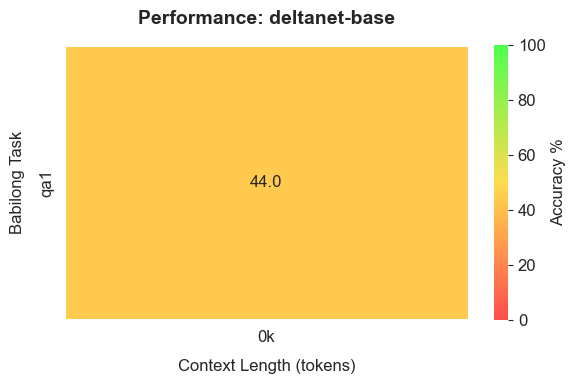

In [15]:
# ==============================================================================
# 7. RESULTS VISUALIZATION (DeltaNet)
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
from pathlib import Path

# 1. Define Model Name (MUST match the logic in Block 6)
# If you changed MODEL_NAME in Block 6 manually, update it here too.
CURRENT_MODEL_NAME = "deltanet-adapter" if 'USE_ADAPTER' in locals() and USE_ADAPTER else "deltanet-base"

# 2. Locate Results
RESULTS_DIR = Path(RESULTS_FOLDER) / CURRENT_MODEL_NAME
print(f"📊 Analyzing results from: {RESULTS_DIR}")

# 3. Initialize Matrix
accuracy_matrix = np.zeros((len(TASKS), len(SPLIT_NAMES)))

# 4. Read Data
for j, task in enumerate(TASKS):
    for i, split_name in enumerate(SPLIT_NAMES):
        
        # Match filenames generated in Block 6: e.g., "qa1_0k.csv"
        csv_path = RESULTS_DIR / f"{task}_{split_name}.csv"
        
        if not csv_path.exists():
            print(f'⚠️ Missing file: {csv_path} (Skipping...)')
            accuracy_matrix[j, i] = 0 
            continue

        try:
            df = pd.read_csv(csv_path)
            
            # The Evaluation Loop saves a 'correct' column (True/False)
            if 'correct' in df.columns:
                acc = df['correct'].mean() * 100
                accuracy_matrix[j, i] = acc
            else:
                print(f"❌ Error: Column 'correct' missing in {csv_path}")
                accuracy_matrix[j, i] = 0
            
        except Exception as e:
            print(f"Error processing {task}/{split_name}: {e}")
            accuracy_matrix[j, i] = 0

# 5. Plotting
print("\nAccuracy Matrix (%):")
print(accuracy_matrix)

# Style
plt.rc('font', size=12)
# Custom Red-Yellow-Green Colormap
cmap = LinearSegmentedColormap.from_list('ryg', ["#ff4d4d", "#ffdb4d", "#4dff4d"], N=256)

# Dynamic Figure Size
fig, ax = plt.subplots(figsize=(max(6, len(SPLIT_NAMES)*1.5), max(4, len(TASKS)*0.8)))

# Heatmap
sns.heatmap(
    accuracy_matrix, 
    cmap=cmap, 
    vmin=0, vmax=100, 
    annot=True, fmt=".1f",
    linewidths=1, linecolor='white',
    xticklabels=SPLIT_NAMES, 
    yticklabels=TASKS, 
    ax=ax,
    cbar_kws={'label': 'Accuracy %'}
)

# Labels
ax.set_title(f'Performance: {CURRENT_MODEL_NAME}', pad=15, fontsize=14, fontweight='bold')
ax.set_xlabel('Context Length (tokens)', labelpad=10)
ax.set_ylabel('Babilong Task', labelpad=10)

plt.tight_layout()
plt.show()